In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False,
    'font.family':'monospace'
})
import seaborn as sns

## Loading the dataset, pre-processing, and analysing the data

In [2]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,...,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
1,200007,15.500000,2.121320,14.0,17.0,23.000000,1.414214,22.0,24.0,8.900000,...,8.0,10.0,10.300000,1.272792,9.4,11.2,44,M,30,0
2,200009,9.500000,2.121320,8.0,11.0,23.333333,2.081666,21.0,25.0,8.000000,...,15.0,21.0,12.471429,1.471637,10.5,14.3,47,F,51,0
3,200012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.900000,NaN,4.9,4.9,33,F,10,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,...,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30484,299992,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,...,8.0,23.0,14.134783,3.781727,8.1,22.1,41,M,499,0
30485,299993,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,...,12.0,15.0,12.600000,0.605530,12.0,13.3,26,M,67,0
30486,299994,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,...,28.0,63.0,10.076190,2.642329,5.3,14.5,74,F,152,1
30487,299998,11.500000,1.732051,10.0,14.0,23.500000,1.290994,22.0,25.0,8.800000,...,20.0,22.0,9.900000,1.210372,7.9,11.0,87,M,46,1


Handling missing data in a strict way: 
- If some feature is missing, get rid of that entry completely. 
- This does have implications, thats why I have also explored imputation techniques to "maximize data". 

In [3]:
# Data available in most of the patients:
# This will drop the patients missing this vital information:
df = cohort_data.dropna(subset=[
    'anion_gap_mean', 'anion_gap_min', 'anion_gap_max', 'anion_gap_sd',
    'bicarbonate_mean', 'bicarbonate_min', 'bicarbonate_max', 'bicarbonate_sd',
    'calcium_total_mean', 'calcium_total_min', 'calcium_total_max', 'calcium_total_sd',
    'chloride_mean', 'chloride_min', 'chloride_max', 'chloride_sd',
    'creatinine_mean', 'creatinine_min', 'creatinine_max', 'creatinine_sd',
    'glucose_mean', 'glucose_min', 'glucose_max', 'glucose_sd',
    'hematocrit_mean', 'hematocrit_min', 'hematocrit_max', 'hematocrit_sd',
    'hemoglobin_mean', 'hemoglobin_min', 'hemoglobin_max', 'hemoglobin_sd',
    'mchc_mean', 'mchc_min', 'mchc_max', 'mchc_sd',
    'mcv_mean', 'mcv_min', 'mcv_max', 'mcv_sd',
    'magnesium_mean', 'magnesium_min', 'magnesium_max', 'magnesium_sd',
    'pt_mean', 'pt_min', 'pt_max', 'pt_sd',
    'phosphate_mean', 'phosphate_min', 'phosphate_max', 'phosphate_sd',
    'platelet_count_mean', 'platelet_count_min', 'platelet_count_max', 'platelet_count_sd',
    'potassium_mean', 'potassium_min', 'potassium_max', 'potassium_sd',
    'rdw_mean', 'rdw_min', 'rdw_max', 'rdw_sd',
    'red_blood_cells_mean', 'red_blood_cells_min', 'red_blood_cells_max', 'red_blood_cells_sd',
    'sodium_mean', 'sodium_min', 'sodium_max', 'sodium_sd',
    'urea_nitrogen_mean', 'urea_nitrogen_min', 'urea_nitrogen_max', 'urea_nitrogen_sd',
    'white_blood_cells_mean', 'white_blood_cells_min', 'white_blood_cells_max', 'white_blood_cells_sd',
    'age',  'gender', 'icu_los_hours', 'target'
    ])

# # Drop sparse columns (missing values for many ICU entries)
df = df.dropna(axis=1, how='any')
df

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,...,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,...,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
7,200028,13.200000,0.836660,12.0,14.0,17.400000,2.302173,15.0,21.0,8.100000,...,10.0,14.0,6.880000,4.276915,3.9,14.3,65,M,69,0
8,200030,14.666667,1.322876,13.0,17.0,19.333333,1.732051,17.0,22.0,9.066667,...,16.0,28.0,12.212500,1.342107,10.3,14.0,54,M,147,0
11,200039,11.625000,0.916125,10.0,13.0,23.000000,2.449490,19.0,28.0,7.980000,...,5.0,16.0,13.437500,1.283898,11.0,15.1,69,F,155,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,299988,10.285714,2.468286,7.0,18.0,25.685714,3.809982,17.0,30.0,7.208696,...,10.0,31.0,8.066667,4.451942,1.9,25.2,33,M,516,1
30484,299992,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,...,8.0,23.0,14.134783,3.781727,8.1,22.1,41,M,499,0
30485,299993,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,...,12.0,15.0,12.600000,0.605530,12.0,13.3,26,M,67,0
30486,299994,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,...,28.0,63.0,10.076190,2.642329,5.3,14.5,74,F,152,1


Summary of the filtered data

In [4]:
print(df.info())        # Data types and non-null counts
print(df.describe())    # Summary stats for numeric columns
print(df.describe(include='object')) 

<class 'pandas.core.frame.DataFrame'>
Index: 13964 entries, 0 to 30487
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   icustay_id              13964 non-null  int64  
 1   anion_gap_mean          13964 non-null  float64
 2   anion_gap_sd            13964 non-null  float64
 3   anion_gap_min           13964 non-null  float64
 4   anion_gap_max           13964 non-null  float64
 5   bicarbonate_mean        13964 non-null  float64
 6   bicarbonate_sd          13964 non-null  float64
 7   bicarbonate_min         13964 non-null  float64
 8   bicarbonate_max         13964 non-null  float64
 9   calcium_total_mean      13964 non-null  float64
 10  calcium_total_sd        13964 non-null  float64
 11  calcium_total_min       13964 non-null  float64
 12  calcium_total_max       13964 non-null  float64
 13  chloride_mean           13964 non-null  float64
 14  chloride_sd             13964 non-null  flo

Dropping the ICUSTAY_ID and the gender:

In [5]:
df = df.drop('icustay_id', axis=1)
df = df.drop('gender', axis=1)
df

,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,calcium_total_sd,...,urea_nitrogen_sd,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,icu_los_hours,target
0,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,0.292770,...,4.577377,10.0,21.0,26.471429,13.176711,13.2,43.9,48,141,0
4,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,0.057735,...,1.732051,21.0,24.0,13.233333,2.203028,10.7,14.7,85,41,0
7,13.200000,0.836660,12.0,14.0,17.400000,2.302173,15.0,21.0,8.100000,0.316228,...,1.870829,10.0,14.0,6.880000,4.276915,3.9,14.3,65,69,0
8,14.666667,1.322876,13.0,17.0,19.333333,1.732051,17.0,22.0,9.066667,0.774597,...,4.131759,16.0,28.0,12.212500,1.342107,10.3,14.0,54,147,0
11,11.625000,0.916125,10.0,13.0,23.000000,2.449490,19.0,28.0,7.980000,0.178885,...,4.062019,5.0,16.0,13.437500,1.283898,11.0,15.1,69,155,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,10.285714,2.468286,7.0,18.0,25.685714,3.809982,17.0,30.0,7.208696,0.301380,...,6.448825,10.0,31.0,8.066667,4.451942,1.9,25.2,33,516,1
30484,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,0.255597,...,4.662524,8.0,23.0,14.134783,3.781727,8.1,22.1,41,499,0
30485,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,0.216025,...,1.224745,12.0,15.0,12.600000,0.605530,12.0,13.3,26,67,0
30486,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,0.316228,...,12.102873,28.0,63.0,10.076190,2.642329,5.3,14.5,74,152,1


Preparing the final datasets

In [6]:
dataset = np.array(df)
y = np.array(df['target'])
X = np.array(df.drop('target', axis=1))
print(np.shape(dataset))
print(np.shape(X))
print(np.shape(y))

# Random shuffle and split 70-30 into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, shuffle=True)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

print(f'# Readmissions in Train: {np.sum(y_train)}')
print(f'# Readmissions in Test: {np.sum(y_test) }')
print(f'% Readmissions in Train: {np.mean(y_train) * 100}')
print(f'% Readmissions in Test: {np.mean(y_test) * 100}')

(13964, 87)
(13964, 86)
(13964,)
(9774, 86)
(4190, 86)
(9774,)
(4190,)
# Readmissions in Train: 1298
# Readmissions in Test: 574
% Readmissions in Train: 13.280130959688972
% Readmissions in Test: 13.699284009546538


### Vanilla Logistic Regression

In [7]:
# Training the LR 
model = LogisticRegression(max_iter=500_000)
model.fit(X_train, y_train)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500000)

In [8]:
# Calculate training error for the vanilla Logistic Regression model
y_train_pred = model.predict(X_train)
train_error = np.mean(y_train_pred != y_train)
print(f"Training error (Vanilla LR): {train_error:.3f}")

# Calculate test error for the vanilla Logistic Regression model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
test_error = np.mean(y_pred != y_test)
print(f"Test error (Vanilla LR): {test_error:.3f}")

Training error (Vanilla LR): 0.133
Test error (Vanilla LR): 0.138


Classification Report:

                    precision    recall  f1-score   support

No Readmission (0)       0.86      1.00      0.93      3616
   Readmission (1)       0.42      0.02      0.04       574

          accuracy                           0.86      4190
         macro avg       0.64      0.51      0.48      4190
      weighted avg       0.80      0.86      0.80      4190

AUROC for class 1 (Readmission): 0.650


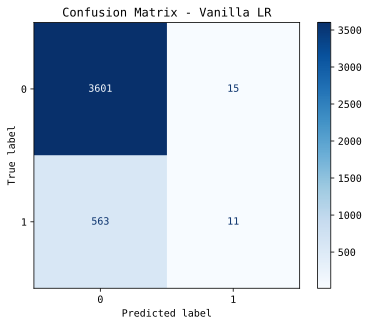

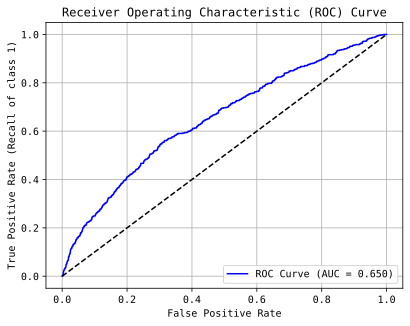

In [9]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Vanilla LR")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Readmission (0)", "Readmission (1)"]))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
np.savez('../results/lr_base_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall of class 1)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
print(f"AUROC for class 1 (Readmission): {roc_auc:.3f}")

## Logistic Regression - Balancing techniques
- Downsampling the majority class.
- Upweight the loss of majority class.
- _Source_:
https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets

In [10]:
from sklearn.utils import resample

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

train_df = pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name="y")], axis=1)
majority_df = train_df[train_df.y == 0]
minority_df = train_df[train_df.y == 1]

print("Before downsampling:", np.bincount(y_train))

frac = 4 # This is to change the downsampling factor 4 means the ratio of min:maj = 1:4
majority_down = resample(majority_df, replace=False, n_samples=len(minority_df) * 4, random_state=7)
train_downsampled = pd.concat([majority_down, minority_df]).sample(frac=1, random_state=7)

X_train_down = train_downsampled.drop(columns=["y"]).values
y_train_down = train_downsampled["y"].values

print("After  downsampling:", np.bincount(y_train_down))

Before downsampling: [8476 1298]
After  downsampling: [5192 1298]



Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93      3616
           1       0.00      0.00      0.00       574

    accuracy                           0.86      4190
   macro avg       0.43      0.50      0.46      4190
weighted avg       0.74      0.86      0.80      4190

Confusion Matrix:
 [[3615    1]
 [ 574    0]]
AUC Score: 0.6498927530757608


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


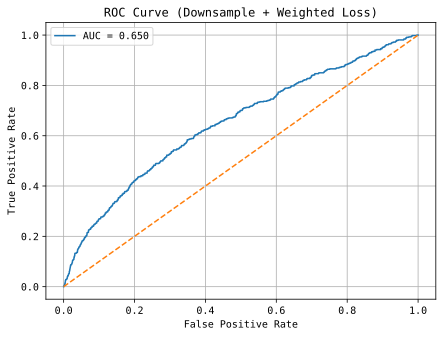

In [12]:
# train
clf = LogisticRegression(max_iter=500000, class_weight={1:1, 0:frac})
clf.fit(X_train_down, y_train_down)

# evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
np.savez('../results/lr_downsample_upweighted_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Downsample + Weighted Loss)")
plt.legend()
plt.grid(True)
plt.show()